# Tuning Script

In [25]:
# Parameters subject to change in every script - involved in naming

MODEL = 'lgbc'
FEATURE_IMPORTANCE_ORDERING = 'xgb'
PREPROCESSING = 'Baseline'
TUNER = 'jiaochengb-balaccu'
FEATURE_ENGINEERING = 'tfidf'
EXPERIMENT = 'additional_features'

---

In [26]:
# detect whether this is a google environment

COLAB_ENVIRONMENT = False

try:
    from google.colab import drive
    drive.mount('/content/drive')
    COLAB_ENVIRONMENT = True
except:
    pass

In [27]:
import sys
import os
import pickle
from scipy.sparse import load_npz

if COLAB_ENVIRONMENT:
    py_file_location = "./drive/MyDrive/LAB/COMP90051-A1__Groupwork__Py/PrivatePackages" # my private packages are stored here
    home_directory = './drive/MyDrive/LAB/COMP90051-A1__Groupwork__Py/' # my home directory is stored in ./LAB of google drive
    if MODEL == 'ebc':
        !pip install interpret==0.5.0
    elif MODEL == 'cbc':
        !pip install catboost
else:
    py_file_location = '../../PrivatePackages'
    home_directory = '../../'

sys.path.append(os.path.abspath(py_file_location))

from Tuners import JiaoChengB_BalAccu

import pandas as pd

In [28]:
## Parameters that are same for every script

SEED = 2608

TASK_TYPE = 'Classification' # this task is a classification task

TUNE_FEATURES_AS_HYPERPARAMETERS = False # we have decided to tune features as hp

---

In [29]:
# model to use to tune
from lightgbm import LGBMClassifier as clf

# what values to try for each hyperparameter
parameter_choices = {
    'n_estimators': (25, 50, 100, 200, 400, 800),
    'max_depth': (3, 6, 12, 24, 48, 96, 192),
    'subsample': (0.4, 0.55, 0.7, 0.85, 1),
    'colsample_bytree': (0.4, 0.55, 0.7, 0.85, 1),
    'learning_rate': (0.00000001, 0.000001, 0.0001, 0.01, 0.1),
    'reg_alpha': (0.0001, 0.001, 0.01, 0.1, 1, 10)
}

# what values to set non-tuneable parameters/hyperparameters
non_tunable_hyperparameters_dict = {
                                    'random_state': 19260817,
                                    'n_jobs': -1,
                                    'warnings': 'none'
                                    }

tuning_order = [
    # 'features',
    'max_depth',
    'subsample',
    'colsample_bytree',
    'n_estimators',
    'reg_alpha',
    'learning_rate',
]

default_hyperparameter_values = {'n_estimators': 100, 'max_depth': 12, 'subsample': 0.7, 'colsample_bytree': 0.7, 'reg_alpha': 0.01, 'learning_rate': 0.01, 'features': 0}
default_hyperparameter_values = {'n_estimators': 100, 'max_depth': 12, 'subsample': 0.7, 'colsample_bytree': 0.7, 'reg_alpha': 0.01, 'learning_rate': 0.01}

---

Read in and Prepare Data

In [30]:
train_x = load_npz(home_directory + f'data/curated/baseline/train_{FEATURE_ENGINEERING}_{EXPERIMENT}_x.npz')
val_x = load_npz(home_directory + f'data/curated/baseline/val_{FEATURE_ENGINEERING}_{EXPERIMENT}_x.npz')
test_x = load_npz(home_directory + f'data/curated/baseline/test_{FEATURE_ENGINEERING}_{EXPERIMENT}_x.npz')

with open(home_directory + f'data/curated/baseline/train_{EXPERIMENT}_y.pkl', 'rb') as f:
    train_y = pickle.load(f)
with open(home_directory + f'data/curated/baseline/val_{EXPERIMENT}_y.pkl', 'rb') as f:
    val_y = pickle.load(f)
with open(home_directory + f'data/curated/baseline/test_{EXPERIMENT}_y.pkl', 'rb') as f:
    test_y = pickle.load(f)

In [31]:
# Import feature importance ordering

with open(f'{home_directory}models/{FEATURE_IMPORTANCE_ORDERING}_{FEATURE_ENGINEERING}_feature_importance_ordering_{EXPERIMENT}.pickle', 'rb') as f:
    feature_importance_ordering = pickle.load(f)

[LightGBM] [Info] Number of positive: 2799, number of negative: 9801
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.379010 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 349911
[LightGBM] [Info] Number of data points in the train set: 12600, number of used features: 6929
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.222143 -> initscore=-1.253222
[LightGBM] [Info] Start training from score -1.253222


<Figure size 5000x1000 with 0 Axes>

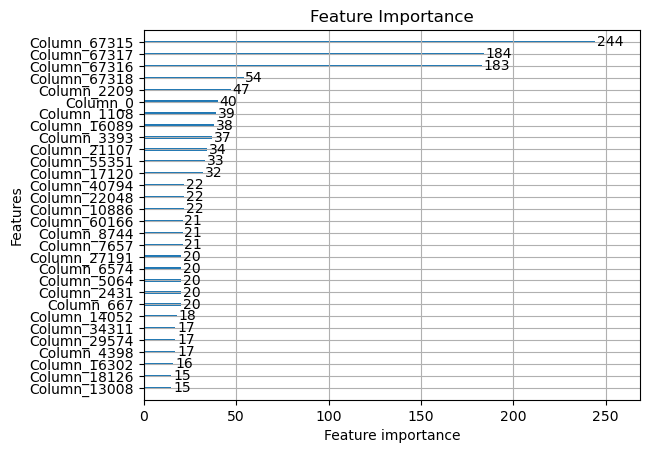

In [32]:
import lightgbm as lgb
import matplotlib.pyplot as plt

# Train your LightGBM model
params = {
    'objective': 'binary',
    'metric': 'binary_logloss',
    'num_leaves': 31,
    'learning_rate': 0.05,
    'feature_fraction': 0.9
}

# Assuming you have your training data in X_train and labels in y_train
train_data = lgb.Dataset(train_x, label=train_y)

# Train the model
model = lgb.train(params, train_data, num_boost_round=100)

# Get feature importance
feature_importance = model.feature_importance()

# Get feature names
feature_names = model.feature_name()

# Plot feature importance
plt.figure(figsize=(50, 10))
lgb.plot_importance(model, max_num_features=30) # Change max_num_features as needed
plt.title("Feature Importance")
plt.show()

Set parameters

In [8]:
# initialisation
tuner = JiaoChengB_BalAccu.JiaoChengB()

print('---')

# define what model we are tuning
tuner.read_in_model(clf, TASK_TYPE)

print('---')

# read in the data for training and validation
tuner.read_in_data(train_x, train_y, val_x, val_y, test_x, test_y)

print('---')

# set what hp values to tune
tuner.set_hyperparameters(parameter_choices)
# WARNING: this may take a while if no. tuneable hyperparameters are large

print('---')

# set up hp values that need to be changed from default but NOT to be tuned
tuner.set_non_tuneable_hyperparameters(non_tunable_hyperparameters_dict)

print('---')

# set up feature importance ordering

if TUNE_FEATURES_AS_HYPERPARAMETERS:
  tuner.set_features(feature_importance_ordering)
  # WARNING: this may take a while if no. tuneable hyperparameters are large

print('---')

# set up the order of hyperparameters when iteratively tuning using JiaoCheng
tuner.set_tuning_order(tuning_order)

print('---')

# set up the default hp values for first iteration of tuning JiaoCheng
tuner.set_hyperparameter_default_values(default_hyperparameter_values)

print('---')

# try: # try to read in previous results to continue tuning ...
#   tuner.read_in_tuning_result_df(f'{home_directory}models/tuning/{TUNER}_{MODEL}_{FEATURE_IMPORTANCE_ORDERING}_{FEATURE_ENGINEERING}_{PREPROCESSING}.csv')
# except:
#   print('No previous tuning data read in')

print('---')

# set up where to save the tuning result csv
tuner.set_tuning_result_saving_address(f'{home_directory}models/tuning_results/{TUNER}_{MODEL}_{FEATURE_IMPORTANCE_ORDERING}_{FEATURE_ENGINEERING}_{EXPERIMENT}_{PREPROCESSING}.csv')

print('---')

# set up where to save the current best model
tuner.set_best_model_saving_address(f'{home_directory}models/tmp_models/{TUNER}_{MODEL}_{FEATURE_IMPORTANCE_ORDERING}_{FEATURE_ENGINEERING}_{EXPERIMENT}_{PREPROCESSING}')

JiaoCheng Initialised
---
Successfully read in model <class 'lightgbm.sklearn.LGBMClassifier'>, which is a Classification model
---
Read in Train X data
Read in Train y data
Read in Val X data
Read in Val y data
Read in Test X data
Read in Test y data
---
Successfully recorded hyperparameter choices
---
Successfully recorded non_tuneable_hyperparameter choices
---
---
---
---
---
Successfully set tuning output address
---
Successfully set best model output address


In [9]:
# ignore warnings

import warnings
warnings.filterwarnings("ignore")

In [10]:
# begin tuning ... (or continue training)

tuner.tune()


Default combo: [2, 2, 2, 2, 3, 2] 


FEATURE_INDEX: 0 (max_depth) ROUND 1

Round 1 
Hyperparameter: max_depth (index: 1) 

[LightGBM] [Warning] Unknown parameter: warnings


[LightGBM] [Warning] Unknown parameter: warnings
[LightGBM] [Info] Number of positive: 2800, number of negative: 9800
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.247223 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 354419
[LightGBM] [Info] Number of data points in the train set: 12600, number of used features: 6997
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.222222 -> initscore=-1.252763
[LightGBM] [Info] Start training from score -1.252763
[LightGBM] [Warning] Unknown parameter: warnings
[LightGBM] [Warning] Unknown parameter: warnings
[LightGBM] [Warning] Unknown parameter: warnings
Trained and Tested combination 1 of 31500: (2, 0, 2, 2, 3, 2), taking 2.02 seconds to get val score of 0.5008
        Current best combo: (2, 0, 2, 2, 3, 2) with val score 0.5008
[LightGBM] [Warning] Unknown parameter: warnings
[LightGBM] [Warn

In [13]:
max_index = tuner.tuning_result['Test balanced_accu'].idxmax()
tuner.tuning_result.loc[max_index]

n_estimators                800.0
max_depth                    12.0
subsample                     0.7
colsample_bytree              1.0
learning_rate                 0.1
reg_alpha                     1.0
Train accu               0.999841
Val accu                 0.863704
Test accu                0.875185
Train balanced_accu       0.99977
Val balanced_accu            0.76
Test balanced_accu       0.773333
Train f1                 0.999841
Val f1                    0.85667
Test f1                   0.86815
Train precision          0.999841
Val precision            0.856689
Test precision           0.869708
Train recall             0.999841
Val recall               0.863704
Test recall              0.875185
Time                        13.79
random_state           19260817.0
n_jobs                       -1.0
warnings                     none
Train AP                 0.999365
Val AP                   0.527329
Test AP                  0.560459
Train AUC                 0.99977
Val AUC       

In [15]:
from sklearn.metrics import balanced_accuracy_score
from sklearn.model_selection import train_test_split
import json

with open(f'{home_directory}models/tmp_models/{TUNER}_{MODEL}_{FEATURE_IMPORTANCE_ORDERING}_{FEATURE_ENGINEERING}_{EXPERIMENT}_{PREPROCESSING}.pickle', 'rb') as f:
    clf = pickle.load(f)
# with open('../models/xgb_tfidf_feature_importance_ordering_Baseline.pickle', 'rb') as f:
#     feature_importance_ordering = pickle.load(f)
    

data1 = []
with open('../../data/raw/domain1_train_data.json', 'r') as f:
    for line in f:
        data1.append(json.loads(line))

data2 = []
with open('../../data/raw/domain2_train_data.json', 'r') as f:
    for line in f:
        data2.append(json.loads(line))

# data_test = []
# with open('../../data/raw/test_data.json', 'r') as f:
#     for line in f:
#         data_test.append(json.loads(line))

# future_tfidf = load_npz(f'../../data/curated/baseline/future_tfidf_{EXPERIMENT}_x.npz')

# create domain labels for data
for i in range(len(data1)):
    data1[i]['domain'] = 1
for i in range(len(data2)):
    data2[i]['domain'] = 2

label1 = [instance['label'] for instance in data1]
label2 = [instance['label'] for instance in data2]

train_ix_1, val_test_ix_1 = train_test_split(range(len(data1)), test_size=0.3, random_state=SEED, stratify = label1)
train_ix_2, val_test_ix_2 = train_test_split(range(len(data2)), test_size=0.3, random_state=SEED, stratify = label2)
val_ix_1, test_ix_1 = train_test_split(val_test_ix_1, test_size=0.5, random_state=SEED, stratify = [data1[i]['label'] for i in val_test_ix_1])
val_ix_2, test_ix_2 = train_test_split(val_test_ix_2, test_size=0.5, random_state=SEED, stratify = [data2[i]['label'] for i in val_test_ix_2])

# split data according to the index from train_test_split
train_data_1 = [data1[i] for i in train_ix_1]
val_data_1 = [data1[i] for i in val_ix_1]
test_data_1 = [data1[i] for i in test_ix_1]
train_data_2 = [data2[i] for i in train_ix_2]
val_data_2 = [data2[i] for i in val_ix_2]
test_data_2 = [data2[i] for i in test_ix_2]

# combine the data
train_data = train_data_1 + train_data_2
val_data = val_data_1 + val_data_2
test_data = test_data_1 + test_data_2

train_label = [instance['label'] for instance in train_data]
val_label = [instance['label'] for instance in val_data]
test_label = [instance['label'] for instance in test_data]


train_domain = [instance['domain'] for instance in train_data]
val_domain = [instance['domain'] for instance in val_data]
test_domain = [instance['domain'] for instance in test_data]

val_pred = clf.predict(val_x)
test_pred = clf.predict(test_x)

print(balanced_accuracy_score(val_y, val_pred), balanced_accuracy_score(test_y, test_pred))

print()

val_dom1_pred = [val_pred[i] for i in range(len(val_pred)) if val_domain[i] == 1]
val_dom2_pred = [val_pred[i] for i in range(len(val_pred)) if val_domain[i] == 2]
val_dom1_true = [val_label[i] for i in range(len(val_label)) if val_domain[i] == 1]
val_dom2_true = [val_label[i] for i in range(len(val_label)) if val_domain[i] == 2]

test_dom1_pred = [test_pred[i] for i in range(len(test_pred)) if test_domain[i] == 1]
test_dom2_pred = [test_pred[i] for i in range(len(test_pred)) if test_domain[i] == 2]
test_dom1_true = [test_label[i] for i in range(len(test_label)) if test_domain[i] == 1]
test_dom2_true = [test_label[i] for i in range(len(test_label)) if test_domain[i] == 2]

print(balanced_accuracy_score(val_dom1_true, val_dom1_pred), balanced_accuracy_score(val_dom2_true, val_dom2_pred), \
      (balanced_accuracy_score(val_dom1_true, val_dom1_pred) + balanced_accuracy_score(val_dom2_true, val_dom2_pred)) / 2, balanced_accuracy_score(val_label, val_pred))
print(balanced_accuracy_score(test_dom1_true, test_dom1_pred), balanced_accuracy_score(test_dom2_true, test_dom2_pred), \
        (balanced_accuracy_score(test_dom1_true, test_dom1_pred) + balanced_accuracy_score(test_dom2_true, test_dom2_pred)) / 2, balanced_accuracy_score(test_label, test_pred))

# future_predict = clf.predict(future_tfidf)
# predictions = pd.DataFrame({'id': range(len(future_predict)), 'c6lass': future_predict})
# predictions.to_csv(f'../..//predictions/jiaochengb-balaccu_svm_tfidf_{EXPERIMENT}_Baseline.csv', index=False)

[LightGBM] [Warning] Unknown parameter: warnings
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Unknown parameter: warnings
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
0.765 0.7323809523809524

0.76 0.6163285024154589 0.6881642512077295 0.765
0.7133333333333334 0.5645410628019324 0.6389371980676328 0.7323809523809524
